In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
data_path = os.getcwd()+"/datasets"
atlantic_path = data_path + "/atlantic.csv"
pacific_path = data_path + "/pacific.csv"

atlantic = pd.read_csv(atlantic_path)
pacific = pd.read_csv(pacific_path)

### Data Preprocessing

Converting Longitude and Latitude to floats from strings

In [3]:
# Function to move the last character to the beginning
def move_last_char_to_beginning(s):
    if len(s) > 1:  
        return s[-1] + s[:-1]
    return s 

atlantic['Latitude'] = atlantic['Latitude'].apply(move_last_char_to_beginning)
atlantic['Longitude'] = atlantic['Longitude'].apply(move_last_char_to_beginning)
pacific['Latitude'] = pacific['Latitude'].apply(move_last_char_to_beginning)
pacific['Longitude'] = pacific['Longitude'].apply(move_last_char_to_beginning)

atlantic['Latitude'] = atlantic['Latitude'].str.replace('N', '').str.replace('S', '-').astype(float)
atlantic['Longitude'] = atlantic['Longitude'].str.replace('E', '').str.replace('W', '-').astype(float)

pacific['Latitude'] = pacific['Latitude'].str.replace('N', '').str.replace('S', '-').astype(float)
pacific['Longitude'] = pacific['Longitude'].str.replace('E', '').str.replace('W', '-').astype(float)

Combining Datasets

In [4]:
atlantic['Database'] = 'Atlantic'
pacific['Database'] = 'Pacific'

hurricanes = combined_df = pd.concat([atlantic, pacific], ignore_index=True)
hurricanes.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Database
0,AL011851,UNNAMED,18510625,0,,HU,28.0,-94.8,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,Atlantic
1,AL011851,UNNAMED,18510625,600,,HU,28.0,-95.4,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,Atlantic
2,AL011851,UNNAMED,18510625,1200,,HU,28.0,-96.0,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,Atlantic
3,AL011851,UNNAMED,18510625,1800,,HU,28.1,-96.5,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,Atlantic
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2,-96.8,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,Atlantic


Fixing some features

In [5]:
hurricanes['Basin'] = hurricanes['ID'].str[0:2]
hurricanes['ATCF cyclone number'] = hurricanes['ID'].str[2:4]
hurricanes['Year'] = hurricanes['ID'].str[4:]

In [6]:
hurricanes['Date'] = pd.to_datetime(hurricanes['Date'], format='%Y%m%d')
hurricanes['Time'] = hurricanes['Time'].astype(str) # need to check later to see if this works
hurricanes['Time'] = hurricanes['Time'].str.zfill(4)
hurricanes['Time'] = pd.to_datetime(hurricanes['Time'], format='%H%M').dt.time

In [7]:
hurricanes = hurricanes.drop(columns=['ID'])
hurricanes.head()

,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,...,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Database,Basin,ATCF cyclone number,Year
0,UNNAMED,1851-06-25,00:00:00,,HU,28.0,-94.8,80,-999,-999,...,-999,-999,-999,-999,-999,-999,Atlantic,AL,01,1851
1,UNNAMED,1851-06-25,06:00:00,,HU,28.0,-95.4,80,-999,-999,...,-999,-999,-999,-999,-999,-999,Atlantic,AL,01,1851
2,UNNAMED,1851-06-25,12:00:00,,HU,28.0,-96.0,80,-999,-999,...,-999,-999,-999,-999,-999,-999,Atlantic,AL,01,1851
3,UNNAMED,1851-06-25,18:00:00,,HU,28.1,-96.5,80,-999,-999,...,-999,-999,-999,-999,-999,-999,Atlantic,AL,01,1851
4,UNNAMED,1851-06-25,21:00:00,L,HU,28.2,-96.8,80,-999,-999,...,-999,-999,-999,-999,-999,-999,Atlantic,AL,01,1851


In [8]:
hurricanes.dtypes

Name                           object
Date                   datetime64[ns]
Time                           object
Event                          object
Status                         object
Latitude                      float64
Longitude                     float64
Maximum Wind                    int64
Minimum Pressure                int64
Low Wind NE                     int64
Low Wind SE                     int64
Low Wind SW                     int64
Low Wind NW                     int64
Moderate Wind NE                int64
Moderate Wind SE                int64
Moderate Wind SW                int64
Moderate Wind NW                int64
High Wind NE                    int64
High Wind SE                    int64
High Wind SW                    int64
High Wind NW                    int64
Database                       object
Basin                          object
ATCF cyclone number            object
Year                           object
dtype: object

In [20]:
hurricanes['Formation'] = (hurricanes['Status'].isin([' TD', ' TS', ' HU'])).astype(int)

In [21]:
# To see the counts of each unique value in a column
value_counts = hurricanes['Status'].value_counts()

# To display the counts
print(value_counts)

Status
 TS     27880
 HU     21302
 TD     16856
 EX      4908
 LO      2833
 SS       564
 DB       321
 SD       297
 ET       152
 WV       116
 PT         6
 ST         6
 HU         1
Name: count, dtype: int64


In [22]:
hurricanes.head(20)

,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,...,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Database,Basin,ATCF cyclone number,Year,Formation
0,UNNAMED,1851-06-25,00:00:00,,HU,28.0,-94.8,80,-999,-999,...,-999,-999,-999,-999,-999,Atlantic,AL,01,1851,1
1,UNNAMED,1851-06-25,06:00:00,,HU,28.0,-95.4,80,-999,-999,...,-999,-999,-999,-999,-999,Atlantic,AL,01,1851,1
2,UNNAMED,1851-06-25,12:00:00,,HU,28.0,-96.0,80,-999,-999,...,-999,-999,-999,-999,-999,Atlantic,AL,01,1851,1
3,UNNAMED,1851-06-25,18:00:00,,HU,28.1,-96.5,80,-999,-999,...,-999,-999,-999,-999,-999,Atlantic,AL,01,1851,1
4,UNNAMED,1851-06-25,21:00:00,L,HU,28.2,-96.8,80,-999,-999,...,-999,-999,-999,-999,-999,Atlantic,AL,01,1851,1
5,UNNAMED,1851-06-26,00:00:00,,HU,28.2,-97.0,70,-999,-999,...,-999,-999,-999,-999,-999,Atlantic,AL,01,1851,1
6,UNNAMED,1851-06-26,06:00:00,,TS,28.3,-97.6,60,-999,-999,...,-999,-999,-999,-999,-999,Atlantic,AL,01,1851,1
7,UNNAMED,1851-06-26,12:00:00,,TS,28.4,-98.3,60,-999,-999,...,-999,-999,-999,-999,-999,Atlantic,AL,01,1851,1
8,UNNAMED,1851-06-26,18:00:00,,TS,28.6,-98.9,50,-999,-999,...,-999,-999,-999,-999,-999,Atlantic,AL,01,1851,1
9,UNNAMED,1851-06-27,00:00:00,,TS,29.0,-99.4,50,-999,-999,...,-999,-999,-999,-999,-999,Atlantic,AL,01,1851,1


c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

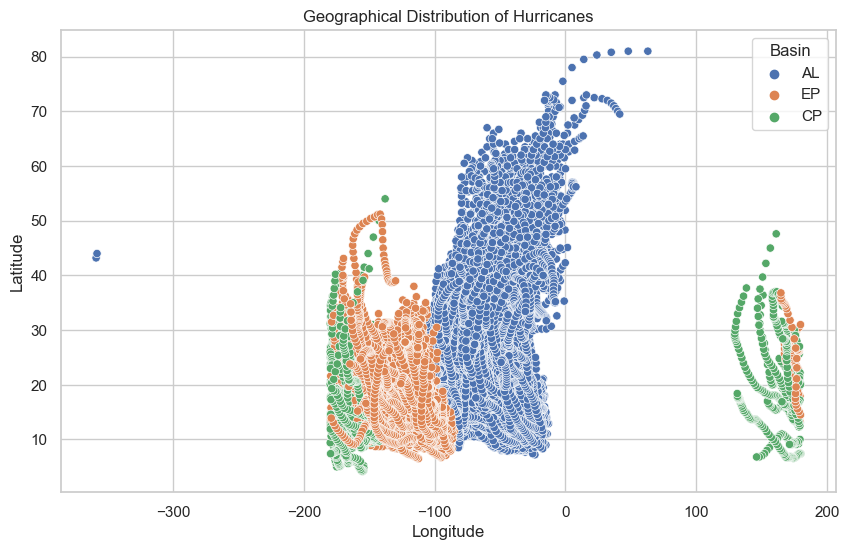

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

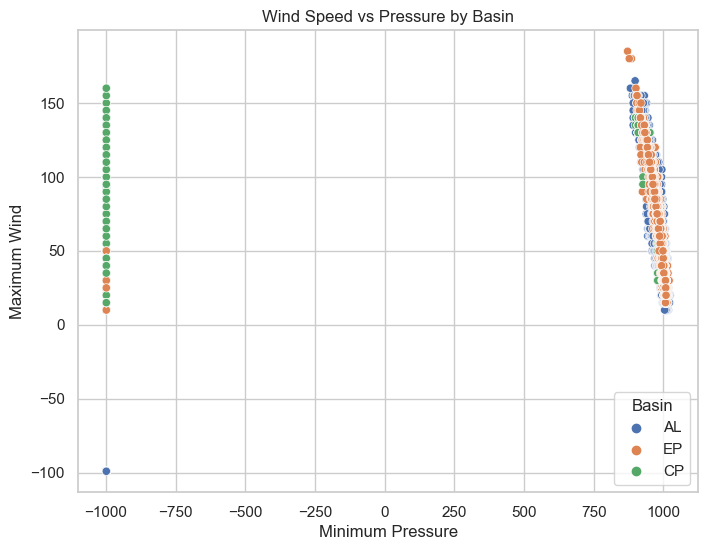

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


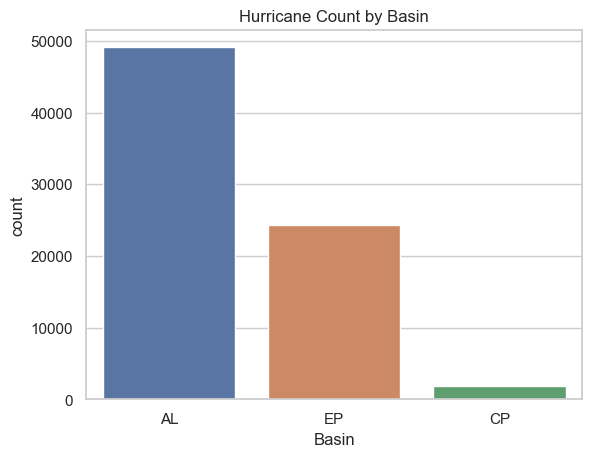

In [11]:
# Latitude vs Longitude: Scatter plot to show locations
plt.figure(figsize=(10,6))
sns.scatterplot(x='Longitude', y='Latitude', hue='Basin', data=hurricanes)
plt.title('Geographical Distribution of Hurricanes')
plt.show()

# Plot relationship between wind speed and pressure
plt.figure(figsize=(8,6))
sns.scatterplot(x='Minimum Pressure', y='Maximum Wind', hue='Basin', data=hurricanes)
plt.title('Wind Speed vs Pressure by Basin')
plt.show()

# Countplot for Basin
sns.countplot(x='Basin', data=hurricanes)
plt.title('Hurricane Count by Basin')
plt.show()


c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.opti

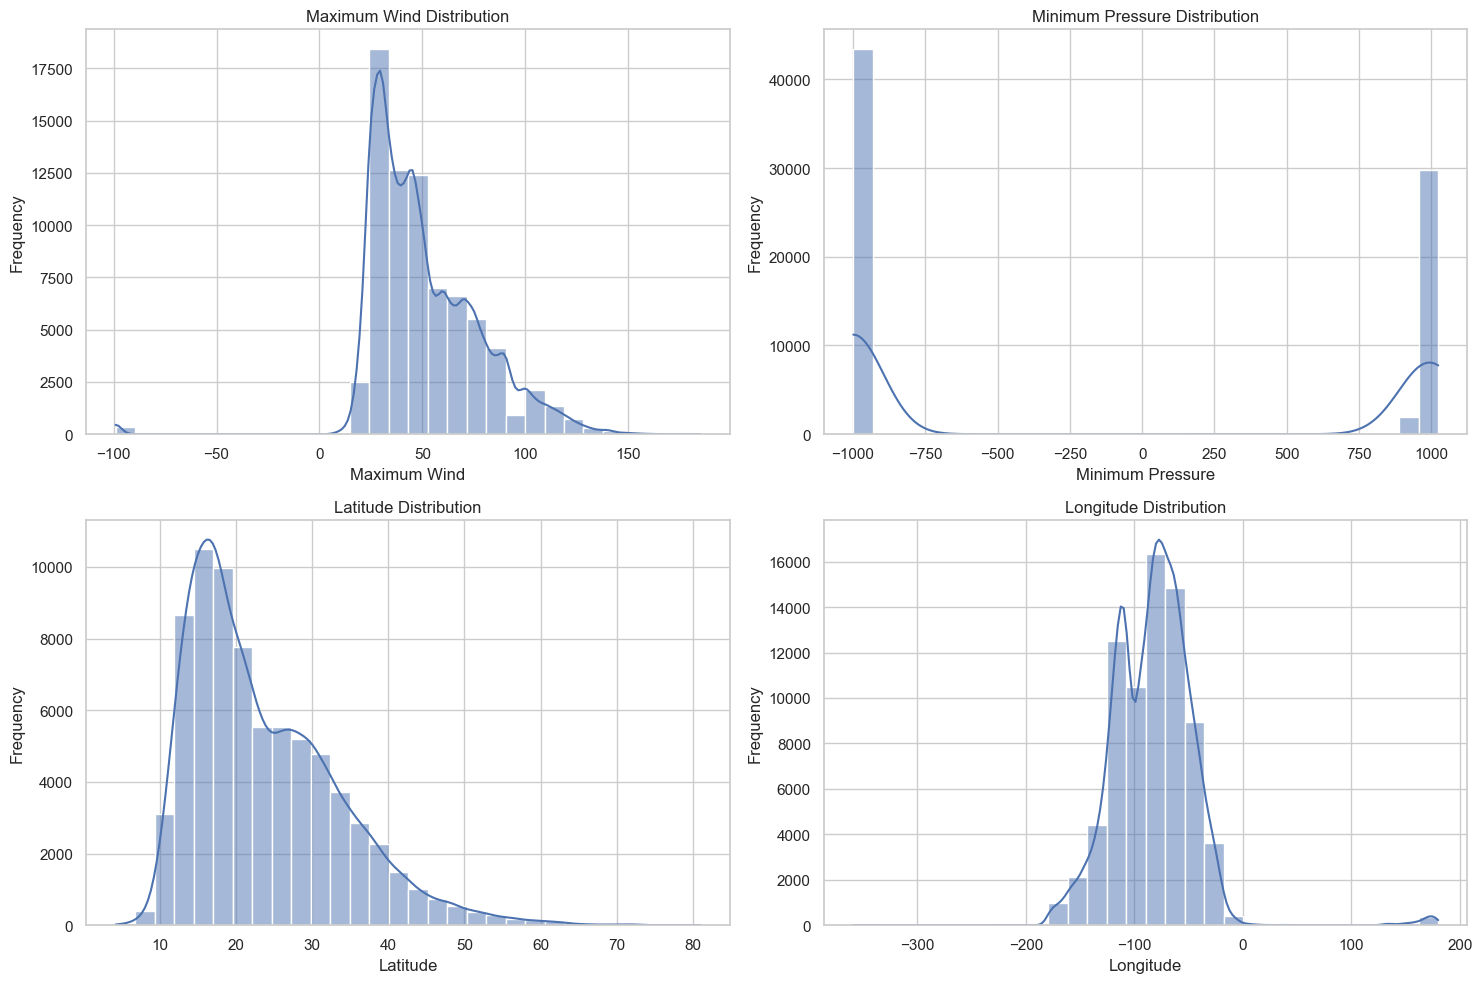

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

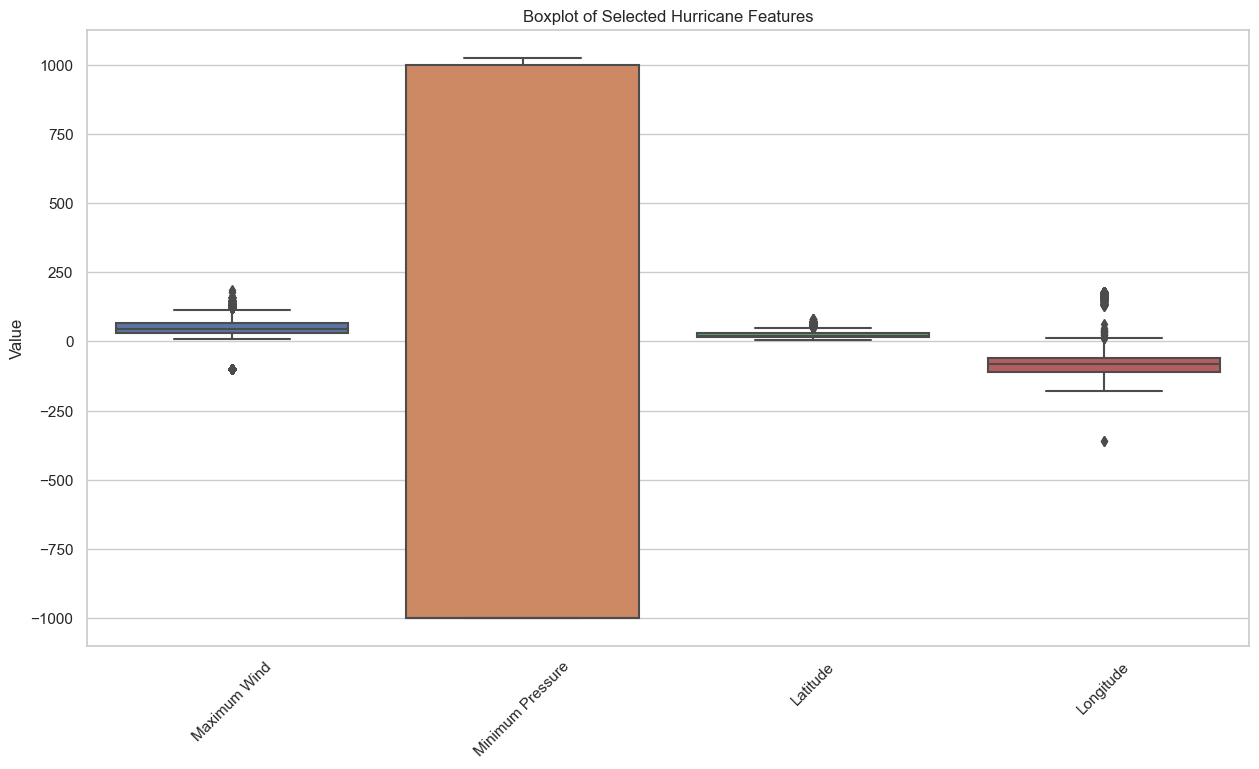

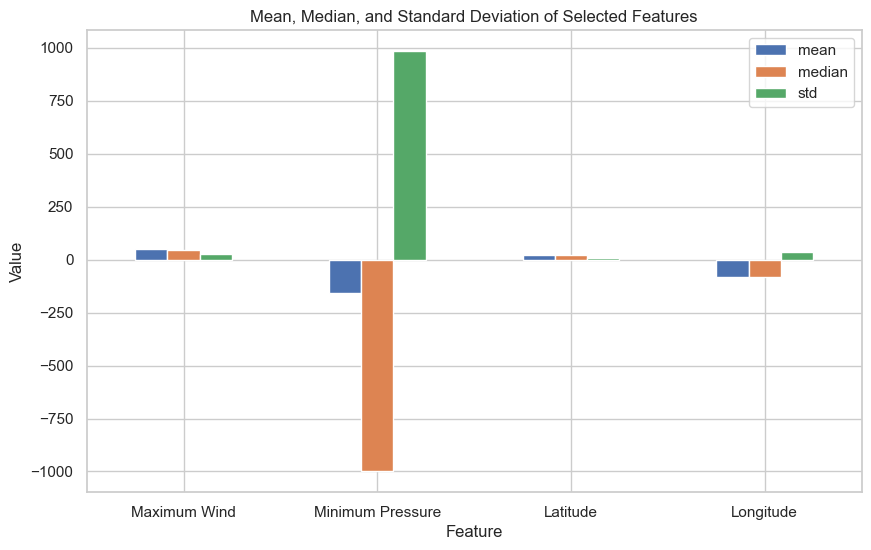

In [12]:

# Set the style of the visualizations
sns.set(style="whitegrid")

# List of columns to analyze
columns_to_analyze = ['Maximum Wind', 'Minimum Pressure', 'Latitude', 'Longitude']

# Plot histograms for each numerical column
plt.figure(figsize=(15, 10))

for i, column in enumerate(columns_to_analyze, 1):
    plt.subplot(2, 2, i)
    sns.histplot(hurricanes[column], kde=True, bins=30)
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot box plots for visualizing outliers and distribution for each column
plt.figure(figsize=(15, 8))

sns.boxplot(data=hurricanes[columns_to_analyze])
plt.title('Boxplot of Selected Hurricane Features')
plt.ylabel('Value')
plt.xticks(rotation=45)

plt.show()

# Plot bar chart for mean, median, and standard deviation
hurricane_stats = hurricanes[columns_to_analyze].describe().T
hurricane_stats['median'] = hurricanes[columns_to_analyze].median()

# Plotting mean, median, and standard deviation
hurricane_stats[['mean', 'median', 'std']].plot(kind='bar', figsize=(10, 6))
plt.title('Mean, Median, and Standard Deviation of Selected Features')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.xticks(rotation=0)

plt.show()


In [23]:
X = hurricanes[['Maximum Wind', 'Minimum Pressure', 'Latitude', 'Longitude']]
y = hurricanes['Formation']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [24]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.33      0.44      2748
           1       0.91      0.98      0.94     19825

    accuracy                           0.90     22573
   macro avg       0.79      0.65      0.69     22573
weighted avg       0.88      0.90      0.88     22573

[[  895  1853]
 [  461 19364]]
